# <center>Convex Potential FLow [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x

**ICNN**: (Input Convex Neural Net)
\begin{equation*}
    \begin{cases}
        z_1 = L_1(x) \\
        z_{k+1} = L_{k+1}^+(s(z_k))+L_{k+1}(x) \\
        F(x) = L_{K+1}^+(s(z_K))+L_{K+1}(x)
    \end{cases}
\end{equation*}
where $s$ is a convex activation function (e.g. softplus), $L^+$ is a linear layer with positive weights (thus strictly increasing in each argument) and $L$ linear layer.

F is convex as a sum of convex function, and composition from a convex function increasing in each argument with a convex function.

**Convex Potential Flow:**
\begin{equation*}
    f_\alpha(x) = \nabla F_\alpha(x)
\end{equation*}
where $F_\alpha(x)=F(x)+\frac{\alpha}{2}\|x\|^2$.


In [29]:
class ICNN(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.params = nn.ParameterList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(d_in,nh))
            self.params.append(nn.Parameter(torch.randn(nh,nh)))
        self.layers.append(nn.Linear(d_in,d_out))
        self.params.append(nn.Parameter(torch.randn(nh,d_out)))
        
        self.softplus = nn.Softplus()

    def forward(self, x):
        for i,layer in enumerate(self.layers):
            if i==0:
                z = layer(x)
            else:
                z = self.softplus(z)@torch.exp(self.params[i-1])+layer(x)
        return z

/home/clement/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


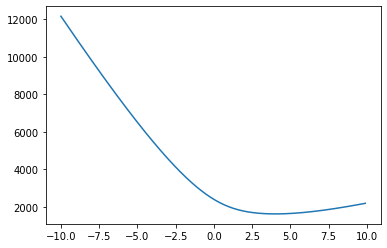

In [40]:
x = torch.arange(-10,10,0.1).reshape(-1,1)

model = ICNN(1,5,1,3)

output = model(x)

plt.plot(x.numpy(),output.detach().numpy())
plt.show()

In [42]:
x = torch.randn(100,2)

model = ICNN(2,5,2,3)

output = model(x)
print(output.size())

torch.Size([100, 2])


In [43]:
def F_alpha(x,alpha=1):
    return model(x)+torch.norm(x)*alpha/2

https://pytorch.org/docs/stable/autograd.html

In [45]:
J = torch.autograd.functional.jacobian(F_alpha, x, create_graph=False, strict=False)
print(J.size())

torch.Size([100, 2, 100, 2])


In [50]:
H = torch.autograd.functional.hessian(F_alpha, x, create_graph=False, strict=False)

RuntimeError: The Tensor returned by the function given to hessian should contain a single element

In [ ]:
def inverse():
    ## cvxsolver (l-BFGS)
    pass

In [ ]:
def log_det():
    ## use polynomial tchebyshev algo
    pass

## Moons

In [ ]:
def train_moons(model, n_epochs=10001):
    d = 2
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    train_loss = []

    for i in range(n_epochs):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            print(i,train_loss[-1])

        if (i + 1) % 500 == 0:
            model.eval()

            xline = torch.linspace(-1.5, 2.5)
            yline = torch.linspace(-.75, 1.25)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                xy, log_s = model(xyinput.to(device))
                zz = (log_likelihood(xy[-1],log_s)).exp().cpu()
                zgrid = zz.reshape(100,100)


                z = base_distr.sample((100,))
                xs, _ = model.backward(z)
                x = xs[-1].detach()
                x = x.cpu().numpy()
                z = z.cpu().numpy()

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.colorbar()
            plt.scatter(x[:,0],x[:,1],c="red")
            plt.scatter(z[:,0],z[:,1],c="green")
            plt.xlim(-1.5,2.5)
            plt.ylim(-0.75,1.25)
            plt.title('iteration {}'.format(i + 1))
            plt.show()
            
    return train_loss

In [ ]:
def loss(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

def log_likelihood(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [ ]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

In [ ]:
train_loss = train_moons(model)

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

In [ ]:
train_loss = train_moons(model)

## MNIST

In [ ]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [ ]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [ ]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [ ]:
def loss(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

In [ ]:
def log_likelihood(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [ ]:
def val():
    d = 28*28
    torch.manual_seed(42)
    r,c = 5,5
    z_random = torch.randn(r,c,d,device=device)
    model.eval()
    zs,log_det = model.backward(z_random.reshape(-1,28*28))
    gen_imgs = zs[-1].view(-1,28,28)

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs.detach().cpu()[cpt],"gray")
            cpt += 1
    plt.show()

In [ ]:
d = 784

## Add batch normalization?
shiftings = [shifting(d//2,1024,d//2,1) for k in range(5)]
scalings = [scaling(d//2,1024,d//2,1) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))
    
model = NormalizingFlows(flows).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

In [ ]:
num_epochs = 101

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()

    train_batch = []

    for n_batch, (data,_) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1,28*28)
        z, log_det = model(data)

        l = loss(z[-1], log_det)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_batch.append(l.item())


    print(epoch, np.mean(train_batch))
    train_losses.append(np.mean(train_batch))

    if epoch % 50 == 0:
        val()


In [ ]:
test_batch = []

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det)

    test_batch.append(l.mean().item())


In [ ]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = log_likelihood / (np.prod(784) * np.log(2.))
print(bpd)

In [ ]:
d = 28*28
torch.manual_seed(42)
r,c = 5,5
z_random = torch.randn(r,c,d,device=device)
model.eval()
zs,log_det = model.backward(z_random.reshape(-1,28*28))
gen_imgs = zs[-1].view(-1,28,28)
gen_imgs = gen_imgs.detach().cpu()
lambd = 1e-6
gen_imgs = (torch.sigmoid(gen_imgs)-lambd)/(1-2*lambd)

cpt = 0
fig,ax = plt.subplots(r,c)
for i in range(r):
    for j in range(c):
        ax[i,j].imshow(gen_imgs[cpt],"gray")
        cpt += 1
plt.show()

## References

<a id="reference1"></a>

[1] Dinh, L., Sohl-Dickstein, J., & Bengio, S. Density estimation using Real NVP. arXiv preprint arXiv:1605.08803. (2016). [link](https://arxiv.org/abs/1605.08803)